In [88]:
import sys, os, math
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from sentence_transformers import SentenceTransformer
from sklearn.metrics import f1_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [89]:
import os
print("Current Working Directory: ", os.getcwd())

Current Working Directory:  /mnt/c/Users/ncian/OneDrive/Desktop/CMPT413-Final-Project/master


# Definitions

In [90]:
# Declare variables at the global scope
dataset_name = None
dataset_path = None
dataset_filename = None
dataset_filename_pickle = None
model_identifier = None
split_result = None
embeddings_path = None
embeddings_filename = None
embeddings_size = None

def set_paths(model_name):
    global dataset_name, dataset_path, dataset_filename, dataset_filename_pickle
    global model_identifier, split_result, embeddings_path, embeddings_filename
    
    dataset_name='mozilla_firefox'
    
    embeddings_size = 100
    
    dataset_path = f'../data'
    dataset_filename = f'{dataset_path}/{dataset_name}.csv'
    dataset_filename_pickle = f'{dataset_path}/{dataset_name}.pkl'
    
    model_identifier = model_name
    split_result = model_identifier.split('/')
    
    embeddings_path = f'{dataset_path}/{dataset_name}_embeddings_{split_result[0]}'
    embeddings_filename = f'{embeddings_path}/{split_result[1]}.pkl'
    


In [221]:
model_name = "intfloat/multilingual-e5-large-instruct"
set_paths(model_name)

# ETL

In [222]:
def perform_ETL():
    df = pd.read_csv(dataset_filename)
    
    def typecast_df(df):
        df['Content'] = df['Title'] + ' ' + df['Description']
        df['Duplicated_issue'] = pd.to_numeric(df['Duplicated_issue'], errors='coerce').astype('Int64')
        df["Issue_id"] = df["Issue_id"].astype('Int64')
        return df
    
    df = typecast_df(df)
    
    missing_issues = df[~df['Duplicated_issue'].isna() & ~df['Duplicated_issue'].isin(df['Issue_id'])]
    
    duplicates_dict = df.groupby('Issue_id')['Duplicated_issue'].apply(set).to_dict()

    def get_all_duplicates(issue_id):
        duplicates = set()
        issues_to_check = [issue_id]

        while issues_to_check:
            current_issue = issues_to_check.pop()
            current_duplicates = duplicates_dict.get(current_issue, set())

            new_duplicates = current_duplicates - duplicates
            duplicates.update(new_duplicates)
            issues_to_check.extend(new_duplicates)

        return list(duplicates) if duplicates else []

    df['Duplicated_issues'] = df['Issue_id'].apply(get_all_duplicates)
    
    def clean_convert_array(arr):
        cleaned = [int(x) for x in arr if not pd.isnull(x)]
        return cleaned

    df['Duplicated_issues'] = df['Duplicated_issues'].apply(clean_convert_array)
    df = df.sort_values(by='Duplicated_issues', key=lambda x: x.str.len(), ascending=False)
    
    num_issues_with_duplicates = df['Duplicated_issues'].apply(lambda x: len(x) > 0).sum()
    
    issue_ids = set(df['Issue_id'])

    def remove_nonexistent_issue_ids(duplicated_issues):
        return [issue_id for issue_id in duplicated_issues if issue_id in issue_ids]

    df['Duplicated_issues'] = df['Duplicated_issues'].apply(remove_nonexistent_issue_ids)
    
    num_issues_with_duplicates = df['Duplicated_issues'].apply(lambda x: len(x) > 0).sum()
    
    df = df.drop(columns=['Duplicated_issue'])
    df.loc[(df['Duplicated_issues'].str.len() == 0) & (df['Resolution'] == 'DUPLICATE'), 'Resolution'] = 'NDUPLICATE'
    df['Duplicates_count'] = df['Duplicated_issues'].apply(len)
    
    df.to_pickle(dataset_filename_pickle)
    

In [223]:
# Perform ETL here if the pickle file does not exist
if not os.path.exists(dataset_filename_pickle):
    perform_ETL()

# Embeddings

### Define Model

In [224]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
model = SentenceTransformer("sentence-transformers/multi-qa-mpnet-base-dot-v1", device=device)
device

'cuda'

### Import Data
- Specify the dataset
- Create "Content" column by concatenating Title and Description for document-level embeddings
- Typecast Duplicated_issue entries to integer

In [225]:
df = pd.read_pickle(dataset_filename_pickle)

### Data Sampling

In [226]:
# Function to find the row with a specific issue_id
# we are finding the duplicates like this
def find_row_by_issue_id(df, issue_id):
    return df.loc[df['Issue_id'] == issue_id]

def find_rows_by_issue_ids(dataframe, issue_ids):
    """
    Returns a DataFrame containing only the rows with matching Issue_id.
    
    :param dataframe: pandas DataFrame containing an 'Issue_id' column
    :param issue_ids: List of issue IDs to find
    :return: DataFrame with only the rows that have a matching Issue_id
    """
    return dataframe[dataframe['Issue_id'].isin(issue_ids)]


In [227]:
# Use a subset of the data for testing
# Comment out the following line to use the entire dataset


df_subset_without_duplicates = df.head(100)

df_subset_without_duplicates.head()

,Issue_id,Priority,Component,Title,Description,Status,Resolution,Version,Created_time,Resolved_time,Content,Duplicated_issues,Duplicates_count
33591,335190,--,General,Ctrl+C does not copy,User-Agent: Mozilla/5.0 (Windows; U; Win...,RESOLVED,DUPLICATE,unspecified,2006-04-23 18:45:42 -0700,2006-04-23 19:50:22 -0700,Ctrl+C does not copy User-Agent: Mozilla...,"[335186, 334862]",2
21703,294616,--,Menus,Open URL in context menu,User-Agent: Mozilla/5.0 (Windows; U; Win...,RESOLVED,DUPLICATE,unspecified,2005-05-18 02:59:14 -0700,2006-01-19 00:20:44 -0800,Open URL in context menu User-Agent: Moz...,"[236336, 227922, 454518]",3
104453,787029,--,Untriaged,movement was canceled in web page Navigation...,User Agent: Mozilla/5.0 (Windows NT 6.1; WOW64...,RESOLVED,DUPLICATE,14 Branch,2012-08-30 06:12:03 -0700,2012-08-30 06:30:58 -0700,movement was canceled in web page Navigation...,"[651803, 787021, 787022]",3
1900,203901,--,Toolbars and Customization,Folders in Bookmarks Toolbar stay Expanded if ...,User-Agent: Mozilla/5.0 (Windows; U; Win...,VERIFIED,DUPLICATE,unspecified,2003-04-30 03:21:59 -0700,2006-11-13 07:16:57 -0800,Folders in Bookmarks Toolbar stay Expanded if ...,"[197227, 203899, 210910]",3
1898,203898,--,Toolbars and Customization,Folders in Bookmarks Toolbar stay Expanded if ...,User-Agent: Mozilla/5.0 (Windows; U; Win...,VERIFIED,DUPLICATE,unspecified,2003-04-30 03:10:53 -0700,2006-11-13 07:23:00 -0800,Folders in Bookmarks Toolbar stay Expanded if ...,"[197227, 203899, 210910]",3


### Adding Duplicates

- approximately we wanna keep the same ratio of duplicates as original data 21%
- so lets add around 25 duplicates to our 100 dataframes
- we will also go to different section of our data frame to have duplicates more spread out
 

In [228]:
def insert_randomly(main_df, insert_dfs):
    """
    Inserts the rows from the list of DataFrames (insert_dfs) into the main DataFrame (main_df) at random positions.
    
    :param main_df: The main DataFrame where the other DataFrames are inserted.
    :param insert_dfs: A list of DataFrames to insert into main_df.
    :return: A new DataFrame with the inserted rows at random positions.
    """
    # Concatenate all the duplicates DataFrames into one for easier manipulation
    df_to_insert = pd.concat(insert_dfs).reset_index(drop=True)
    
    # Calculate the insertion points
    insertion_points = np.random.randint(0, len(main_df), len(df_to_insert))
    
    # Iterate through the insertion points and insert the rows
    for insertion_point, row_to_insert in zip(insertion_points, df_to_insert.iterrows()):
        part1 = main_df.iloc[:insertion_point]
        part2 = main_df.iloc[insertion_point:]
        main_df = pd.concat([part1, pd.DataFrame([row_to_insert[1]]), part2], ignore_index=True)
    
    return main_df

In [229]:
# YOU NEED TO MANUALLY GRAB DUPLICATES FROM ABOVE ISSUES MANUALLY FROM DIFFERENT DATA SETS EQUALLY

duplicates1 = find_rows_by_issue_ids(df, [335186, 334862, 175699, 267261, 200270])
duplicates2 = find_rows_by_issue_ids(df, [197227, 203899, 210910, 364824, 514796, 364797])
duplicates3 = find_rows_by_issue_ids(df, [254967, 265118, 265103, 205129, 215031, 213375])
duplicates4 = find_rows_by_issue_ids(df,[301776, 302946, 269207, 274631])
duplicates5 = find_rows_by_issue_ids(df,[757056, 647655, 174734, 235495, 227241, 172962])

# randomize order of duplicates to have it more natural 
# Use the function to insert duplicates into df_subset_without_duplicates
df_subset = insert_randomly(df_subset_without_duplicates, [duplicates1, duplicates2, duplicates3, duplicates4, duplicates5])

df_subset


,Issue_id,Priority,Component,Title,Description,Status,Resolution,Version,Created_time,Resolved_time,Content,Duplicated_issues,Duplicates_count
0,335190,--,General,Ctrl+C does not copy,User-Agent: Mozilla/5.0 (Windows; U; Win...,RESOLVED,DUPLICATE,unspecified,2006-04-23 18:45:42 -0700,2006-04-23 19:50:22 -0700,Ctrl+C does not copy User-Agent: Mozilla...,"[335186, 334862]",2
1,294616,--,Menus,Open URL in context menu,User-Agent: Mozilla/5.0 (Windows; U; Win...,RESOLVED,DUPLICATE,unspecified,2005-05-18 02:59:14 -0700,2006-01-19 00:20:44 -0800,Open URL in context menu User-Agent: Moz...,"[236336, 227922, 454518]",3
2,787029,--,Untriaged,movement was canceled in web page Navigation...,User Agent: Mozilla/5.0 (Windows NT 6.1; WOW64...,RESOLVED,DUPLICATE,14 Branch,2012-08-30 06:12:03 -0700,2012-08-30 06:30:58 -0700,movement was canceled in web page Navigation...,"[651803, 787021, 787022]",3
3,203901,--,Toolbars and Customization,Folders in Bookmarks Toolbar stay Expanded if ...,User-Agent: Mozilla/5.0 (Windows; U; Win...,VERIFIED,DUPLICATE,unspecified,2003-04-30 03:21:59 -0700,2006-11-13 07:16:57 -0800,Folders in Bookmarks Toolbar stay Expanded if ...,"[197227, 203899, 210910]",3
4,203898,--,Toolbars and Customization,Folders in Bookmarks Toolbar stay Expanded if ...,User-Agent: Mozilla/5.0 (Windows; U; Win...,VERIFIED,DUPLICATE,unspecified,2003-04-30 03:10:53 -0700,2006-11-13 07:23:00 -0800,Folders in Bookmarks Toolbar stay Expanded if ...,"[197227, 203899, 210910]",3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,335186,--,General,Copy and paste stopped working for no reason,User-Agent: Mozilla/5.0 (Windows; U; Win...,RESOLVED,DUPLICATE,unspecified,2006-04-23 17:40:21 -0700,2006-09-24 01:20:16 -0700,Copy and paste stopped working for no reason U...,[334862],1
123,614817,--,Panorama,Windows 7s Aero peek taskbar tabs preview has ...,User-Agent: Mozilla/5.0 (Windows NT 6.1;...,RESOLVED,DUPLICATE,Trunk,2010-11-25 07:22:10 -0800,2010-12-03 15:22:46 -0800,Windows 7s Aero peek taskbar tabs preview has ...,[587440],1
124,266748,--,Keyboard Navigation,ctrl-u no longer clears a line of text; but in...,User-Agent: Mozilla/5.0 (X11; U; Linux i...,VERIFIED,DUPLICATE,unspecified,2004-10-29 12:20:00 -0700,2004-10-29 12:29:47 -0700,ctrl-u no longer clears a line of text; but in...,[260188],1
125,282475,--,Bookmarks & History,Bookmark Icons,User-Agent: Mozilla/5.0 (Macintosh; U; P...,RESOLVED,DUPLICATE,unspecified,2005-02-16 09:24:52 -0800,2006-08-27 05:38:29 -0700,Bookmark Icons User-Agent: Mozilla/5.0 (...,[219846],1


### Save the sampled dataset

In [230]:
df_subset.to_pickle(f'{dataset_path}/{dataset_name}_subset.pkl')

#### Specify the Model

In [231]:
model = SentenceTransformer(model_name, device=device)

### Create Embeddings

#### Create the Embeddings as New Dataframe

In [232]:
def generate_embeddings(content, model, issue_id):
    """Generate embeddings for a given piece of text."""
    
    embedding = model.encode(content, convert_to_tensor=True)

    return embedding.cpu().numpy()

In [233]:
embeddings_df = pd.DataFrame()

embeddings_df['Embedding'] = df_subset.apply(lambda row: generate_embeddings(f"{row['Title']} {row['Content']}" if pd.notna(row['Content']) else row['Title'], model=model, issue_id=row['Issue_id']), axis=1)

embeddings_df['Issue_id'] = df_subset['Issue_id']
embeddings_df['Duplicated_issues'] = df_subset['Duplicated_issues']

In [234]:
def typecast_df(df):
    df['Duplicated_issues'] = df['Duplicated_issues'].apply(lambda x: [int(i) for i in x])
    df["Issue_id"] = df["Issue_id"].astype('Int64')
    return df
embeddings_df = typecast_df(embeddings_df)


embeddings_df.head()

,Embedding,Issue_id,Duplicated_issues
0,"[0.021795597, 0.045323856, -0.019552924, -0.02...",335190,"[335186, 334862]"
1,"[0.020882333, 0.017898196, -0.0343988, -0.0169...",294616,"[236336, 227922, 454518]"
2,"[0.024762442, 0.026727095, -0.0276173, -0.0290...",787029,"[651803, 787021, 787022]"
3,"[0.036155798, 0.026926218, -0.038960505, -0.00...",203901,"[197227, 203899, 210910]"
4,"[0.03654469, 0.027051205, -0.039112423, -0.005...",203898,"[197227, 203899, 210910]"


In [235]:
filename = f'{embeddings_path}/{split_result[1]}.pkl'
directory = os.path.dirname(filename)

os.makedirs(directory, exist_ok=True) # Create the directory if it doesn't exist
embeddings_df.to_pickle(filename)

# Evaluate

In [236]:
df = pd.read_pickle(dataset_filename_pickle)
df['Content'] = df['Title'] + ' ' + df['Description']
df["Issue_id"] = df["Issue_id"].astype('Int64')

In [237]:
embeddings_df = pd.read_pickle(embeddings_filename)
embeddings_df

,Embedding,Issue_id,Duplicated_issues
0,"[0.021795597, 0.045323856, -0.019552924, -0.02...",335190,"[335186, 334862]"
1,"[0.020882333, 0.017898196, -0.0343988, -0.0169...",294616,"[236336, 227922, 454518]"
2,"[0.024762442, 0.026727095, -0.0276173, -0.0290...",787029,"[651803, 787021, 787022]"
3,"[0.036155798, 0.026926218, -0.038960505, -0.00...",203901,"[197227, 203899, 210910]"
4,"[0.03654469, 0.027051205, -0.039112423, -0.005...",203898,"[197227, 203899, 210910]"
...,...,...,...
122,"[0.007853099, 0.030744929, 0.0075757983, -0.01...",335186,[334862]
123,"[0.038895756, 0.028489929, -0.038411047, -0.02...",614817,[587440]
124,"[-0.0019632117, 0.030092532, -0.030704122, -0....",266748,[260188]
125,"[0.05975122, 0.017201856, -0.05542961, -0.0187...",282475,[219846]


#### Add Duplicated_issue and Duplicated_issues Columns to Embeddings Dataframe

In [238]:
embeddings_df = pd.merge(embeddings_df, df[['Issue_id', 'Duplicated_issues']], on='Issue_id', how='left')

### Import Sampled Data (This needs to be ran seperately)

In [239]:
subset_filename = f'{dataset_path}/{dataset_name}_subset.pkl'
embeddings_df = pd.read_pickle(embeddings_filename)

In [240]:
def compute_f1(embeddings_df, threshold=0.5):
    similarity_matrix = cosine_similarity(embeddings_df['Embedding'].tolist())
    true_positives = 0
    false_positives = 0
    false_negatives = 0
    true_negatives = 0

    for i in range(len(embeddings_df)):
        for j in range(i + 1, len(embeddings_df)):
            # Handling noise in data: the content is exact the same (causing the score to be above of thershold) but ids are different and they are not part of eachothers duplicated issues 
            # please check embedding's data inconsistencies section
            if similarity_matrix[i, j] > 0.98:
                continue
            is_duplicate = False

            # Check if i's issue_id is in j's duplicated list or if j's issue_id is in i's duplicated list
            is_duplicate = (embeddings_df['Issue_id'].iloc[j] in embeddings_df['Duplicated_issues'].iloc[i]) or (embeddings_df['Issue_id'].iloc[i] in embeddings_df['Duplicated_issues'].iloc[j])

            is_above_threshold = similarity_matrix[i, j] >= threshold
            if is_duplicate and is_above_threshold:
                true_positives += 1
            elif is_duplicate and not is_above_threshold:
                false_negatives += 1
            elif not is_duplicate and is_above_threshold:
                false_positives += 1
            elif not is_duplicate and not is_above_threshold:
                true_negatives += 1

    precision = true_positives / (true_positives + false_positives) if true_positives + false_positives > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if true_positives + false_negatives > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
    return f1, precision, recall, similarity_matrix, true_positives, false_positives, false_negatives, true_negatives

In [241]:
f1, precision, recall, similarity_matrix, true_positives, false_positives, false_negatives, true_negatives = compute_f1(embeddings_df, threshold=0.622)


# actually duplicates, flagged duplicate 
print('True positives: ', true_positives)

# actually duplicates and not flagged
print('false negative: ', false_negatives)

# not duplicates and not flagged
print('true negative: ', true_negatives)

# not duplicates and flagged
print('false postive: ', false_positives)


print('F1 score:', f1)
print('Precision:', precision)
print('Recall', recall)

True positives:  68
false negative:  0
true negative:  0
false postive:  7908
F1 score: 0.01690701143709597
Precision: 0.008525576730190571
Recall 1.0


In [242]:
def compute_crossEntropy(embeddings_df):
    similarity_matrix = cosine_similarity(embeddings_df['Embedding'].tolist())

    # Prepare lists to store similarity scores and the ground truth labels
    similarity_scores = []
    ground_truth_labels = []

    for i in range(len(embeddings_df)):
        for j in range(i + 1, len(embeddings_df)):
            is_duplicate = False
            # Handling noise in data: the content is exact the same (causing the score to be above of thershold) but ids are different and they are not part of eachothers duplicated issues 
            # please check embedding's data inconsistencies section
            if similarity_matrix[i, j] > 0.98:
                continue
            # Check if i's issue_id is in j's duplicated list or if j's issue_id is in i's duplicated list
            is_duplicate = (embeddings_df['Issue_id'].iloc[j] in embeddings_df['Duplicated_issues'].iloc[i]) or (embeddings_df['Issue_id'].iloc[i] in embeddings_df['Duplicated_issues'].iloc[j])
            ground_truth = 1 if is_duplicate else 0
            
            # Store the similarity score and the ground truth
            similarity_scores.append(similarity_matrix[i, j])
            ground_truth_labels.append(ground_truth)
                        

    similarity_scores_tensor = torch.tensor(similarity_scores)
    ground_truth_labels_tensor = torch.tensor(ground_truth_labels, dtype=torch.float)

    # Apply sigmoid to interpret similarity scores as probabilities
    probabilities = torch.sigmoid(similarity_scores_tensor)
    # Compute binary cross-entropy loss
    loss = F.binary_cross_entropy(probabilities, ground_truth_labels_tensor)
    return loss

In [243]:
loss = compute_crossEntropy(embeddings_df)
print("cross entropy loss is: ", loss)


cross entropy loss is:  tensor(1.1963)


In [244]:
def compute_roc_auc(embeddings_df):
    # Assuming cosine_similarity is a function that computes the cosine similarity matrix
    similarity_matrix = cosine_similarity(embeddings_df['Embedding'].tolist())
    ground_truth = []
    scores = []

    for i in range(len(embeddings_df)):
        for j in range(i + 1, len(embeddings_df)):
            is_duplicate = (embeddings_df['Issue_id'].iloc[j] in embeddings_df['Duplicated_issues'].iloc[i]) or \
                           (embeddings_df['Issue_id'].iloc[i] in embeddings_df['Duplicated_issues'].iloc[j])
            ground_truth.append(int(is_duplicate))
            scores.append(similarity_matrix[i, j])

    # Convert to numpy arrays for sklearn
    ground_truth = np.array(ground_truth)
    scores = np.array(scores)

    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(ground_truth, scores)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    return roc_auc, fpr, tpr

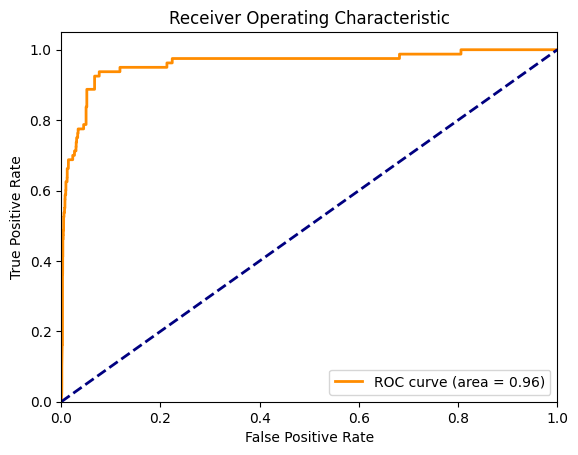

ROC-AUC: 0.9599119429364981


In [245]:
roc_auc, fpr, tpr = compute_roc_auc(embeddings_df)
print(f"ROC-AUC: {roc_auc}")

In [246]:
# Create a folder to save the metrics and images
model_folder = model_identifier.replace('/', '-')
metrics_folder = f"../data/metrics/{model_folder}_metrics"
os.makedirs(metrics_folder, exist_ok=True)

# Export the metrics to a CSV file
metrics_df = pd.DataFrame({
    'Model': [model_identifier],
    'F1 Score': [f1],
    'Precision': [precision],
    'Recall': [recall],
    'ROC AUC': [roc_auc],
    'True Positives': [true_positives],
    'False Positives': [false_positives],
    'False Negatives': [false_negatives],
    'True Negatives': [true_negatives]
})
metrics_filename = f"{metrics_folder}/{model_folder}_metrics.csv"
metrics_df.to_csv(metrics_filename, index=False)

# Save the ROC curve plot
roc_curve_filename = f"{metrics_folder}/{model_folder}_roc_curve.png"
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=('ROC curve (area = %0.2f)' % roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig(roc_curve_filename)
plt.close()

# Save the precision-recall curve plot
pr_curve_filename = f"{metrics_folder}/{model_folder}_pr_curve.png"
plt.figure()
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.savefig(pr_curve_filename)
plt.close()

# Print the filenames of the saved metrics and images
print(f"Metrics saved to: {metrics_filename}")
print(f"ROC curve saved to: {roc_curve_filename}")
print(f"Precision-Recall curve saved to: {pr_curve_filename}")


Metrics saved to: ../data/metrics/intfloat-multilingual-e5-large-instruct_metrics/intfloat-multilingual-e5-large-instruct_metrics.csv
ROC curve saved to: ../data/metrics/intfloat-multilingual-e5-large-instruct_metrics/intfloat-multilingual-e5-large-instruct_roc_curve.png
Precision-Recall curve saved to: ../data/metrics/intfloat-multilingual-e5-large-instruct_metrics/intfloat-multilingual-e5-large-instruct_pr_curve.png
